This is my take to implement ConvNets to solve CIFAR10 classification task

# Fully Connected Network

## Load data

For this part I use Stanfords CS231n gugid to load the cifar10 data

In [ ]:
from fullyConnected import early_stop, build_fc_model_batchnorm, build_CNN, build_CNN_batchnorm
from fullyConnected import build_2xCNN_batchnorm, build_CNN_nopool
from fullyConnected import build_fc_model, update_functions, shared_dataset
from lasagne.layers import  get_all_param_values, count_params, get_all_layers, get_all_params
import numpy as np
from data_utils import get_CIFAR10_data
import theano.tensor as T
import time
import cPickle as pickle

In [2]:
# to auto reload external modules
%load_ext autoreload
%autoreload 2

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


## MLP

In [4]:
num_class = np.unique(data['y_train']).size

X = T.ftensor4('X')
y = T.ivector('y')

In [5]:
# load data to gpu for fast minibatch training
shared_data = shared_dataset(data)
del data

In [7]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]

network = build_fc_model(in_shape=input_shape,
                         num_hidden=hidden_arch,
                         num_out=num_class,
                         in_var=X)

In [ ]:
test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=2048,
                                                                                 l1_reg=0,
                                                                                 l2_reg=.01,
                                                                                 lear_rate=1e-3,
                                                                                 printFreq=200)

In [9]:
min(train_loss_history_), min(val_loss_history_), min(val_error_history_)

(1.4079814, array(1.3544187545776367, dtype=float32), array(0.448))

In [15]:
# plot the training results
import matplotlib.pyplot as plt
%matplotlib inline

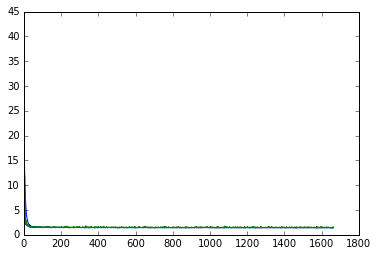

In [12]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [13]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 55.2 %
best test accuracy: 54.1 %


## Add Dropout

In [6]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]
dropout = [.1,.3,.3]

network = build_fc_model(in_shape=input_shape,
                         num_hidden=hidden_arch,
                         num_out=num_class,
                         dropout=dropout,
                         in_var=X)

In [ ]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=2048,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0,
                                                                                 lear_rate=1e-3,
                                                                                 printFreq=200)

## batch normalisation

In [18]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]

network = build_fc_model_batchnorm(in_shape=input_shape,
                                   num_hidden=hidden_arch,
                                   num_out=num_class,
                                   in_var=X)

In [ ]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=2048,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.003,
                                                                                 lear_rate=1e-3,
                                                                                 printFreq=200)

# CNN

Build a simple 3layer CNN
architechture:
    conv - relu - 2x2 maxpool - affine - relu - affine - softmax

In [31]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = 32

network = build_CNN(in_shape=input_shape,
                    num_hidden=hidden_arch,
                    num_filter = num_filter,
                    fil_size = 7,
                    num_out=num_class,
                    in_var=X)

In [123]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.001,
                                                                                 lear_rate=1e-3,
                                                                                 iteration=100,
                                                                                 printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 766
start training
epoch 10, val_loss 1.515931, train_loss 1.421588, error 0.504000, best error 0.504000 ,in 89.863329 secs 

epoch 20, val_loss 1.464987, train_loss 1.352667, error 0.503000, best error 0.503000 ,in 89.489767 secs 

epoch 30, val_loss 1.535198, train_loss 1.330081, error 0.513000, best error 0.477000 ,in 88.422579 secs 

epoch 40, val_loss 1.508159, train_loss 1.317613, error 0.492000, best error 0.463000 ,in 87.452698 secs 

epoch 50, val_loss 1.612777, train_loss 1.305904, error 0.492000, best error 0.459000 ,in 87.260582 secs 

patience reached 

resetting network params to that of the best seen 



In [188]:
weights = get_all_param_values(net)

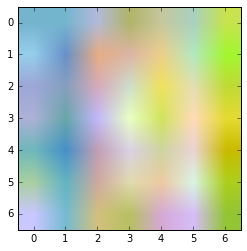

In [265]:
ind = np.random.randint(0, high=31)
im = weights[0][ind,:,:,:].reshape(3,7,7)
im = im.swapaxes(0,2)
im+=abs(im.min(axis=(0,1)))
im *= 255/im.max(axis=(0,1))
plt.imshow(im.astype('uint8'))

## CNN + Batch normalisation

Build a simple 3layer CNN with batch normalisation

architechture:

    conv - relu - 2x2 maxpool - affine - relu - affine - softmax

In [268]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = 32

network = build_CNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = 7,
                              num_out=num_class,
                              in_var=X)

In [269]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-2,
                                                                                 iteration=100,
                                                                                 printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 10, val_loss 1.305629, train_loss 0.278293, error 0.351000, best error 0.348000 ,in 84.481983 secs 

epoch 20, val_loss 1.520522, train_loss 0.242956, error 0.359000, best error 0.342000 ,in 84.147702 secs 

epoch 30, val_loss 1.431203, train_loss 0.222392, error 0.351000, best error 0.322000 ,in 84.772461 secs 

epoch 40, val_loss 1.488086, train_loss 0.198525, error 0.334000, best error 0.322000 ,in 84.041291 secs 

epoch 50, val_loss 1.591749, train_loss 0.202776, error 0.348000, best error 0.322000 ,in 83.780562 secs 

epoch 60, val_loss 1.333655, train_loss 0.189722, error 0.321000, best error 0.301000 ,in 83.713607 secs 

epoch 70, val_loss 1.291978, train_loss 0.170806, error 0.322000, best error 0.301000 ,in 82.216305 secs 

epoch 80, val_loss 1.435140, train_loss 0.164189, error 0.337000, best error 0.301000 ,in 81.244518 secs 

epoch 90, val_loss 1.590224, tr

In [270]:
weights = get_all_param_values(net)

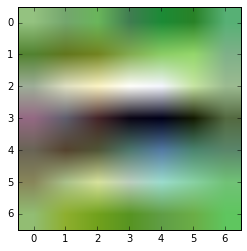

In [291]:
ind = np.random.randint(0, high=31)
im = weights[0][ind,:,:,:].reshape(3,7,7)
im = im.swapaxes(0,2)
im+=abs(im.min(axis=(0,1)))
im *= 255/im.max(axis=(0,1))
plt.imshow(im.astype('uint8'))

## Deeper CNN + Batch normalisation
Build a simple 4layer CNN with batch normalisation

fist conv layer has 7x7 filters and the second has 3x3 filters

architechture:

        (conv - relu - 2x2 maxpool)x2 - affine - relu - affine - softmax

In [294]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = 32

network = build_2xCNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = 7,
                              num_out=num_class,
                              in_var=X)

In [299]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=2048,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-2,
                                                                                 iteration=50,
                                                                                 printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 10, val_loss 1.215559, train_loss 0.132976, error 0.281000, best error 0.280000 ,in 53.014396 secs 

epoch 20, val_loss 1.195995, train_loss 0.121440, error 0.276000, best error 0.274000 ,in 51.729225 secs 

epoch 30, val_loss 1.176005, train_loss 0.111231, error 0.273000, best error 0.273000 ,in 51.722908 secs 

epoch 40, val_loss 1.157622, train_loss 0.102030, error 0.267000, best error 0.267000 ,in 51.721194 secs 

epoch 50, val_loss 1.140275, train_loss 0.093704, error 0.276000, best error 0.267000 ,in 51.696729 secs 



In [300]:
weights = get_all_param_values(net)

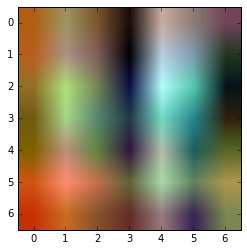

In [310]:
ind = np.random.randint(0, high=31)
im = weights[0][ind,:,:,:].reshape(3,7,7)
im = im.swapaxes(0,2)
im+=abs(im.min(axis=(0,1)))
im *= 255/im.max(axis=(0,1))
plt.imshow(im.astype('uint8'))

## Deeper CNN + Batch normalisation
Build a simple 4layer CNN with batch normalisation with more filters

fist conv layer has 7x7 filters and the second has 3x3 filters

architechture:

        (conv - relu - 2x2 maxpool)x2 - affine - relu - affine - softmax

In [8]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 500
num_filter = [64, 128]
filters = [3,3]

network = build_2xCNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = filters,
                              num_out=num_class,
                              in_var=X)

In [12]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=256,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-3,
                                                                                 iteration=150,
                                                                                 printFreq=30)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 192
start training
epoch 30, val_loss 1.173052, train_loss 0.200253, error 0.331000, best error 0.223000 ,in 521.889631 secs 

epoch 60, val_loss 2.866783, train_loss 0.204561, error 0.542000, best error 0.205000 ,in 521.086501 secs 

epoch 90, val_loss 0.685515, train_loss 0.056368, error 0.211000, best error 0.205000 ,in 520.818964 secs 

epoch 120, val_loss 0.650800, train_loss 0.033078, error 0.205000, best error 0.195000 ,in 529.004199 secs 

epoch 150, val_loss 0.666947, train_loss 0.030752, error 0.205000, best error 0.195000 ,in 527.117913 secs 



In [14]:
test_fn()[1]

array(0.225)

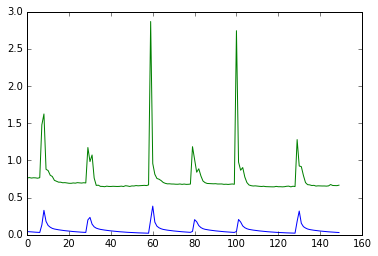

In [16]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

# Build a simpler CNN by avoiding pooling

Here I try to replicate the approach in [ref](http://arxiv.org/pdf/1412.6806.pdf). However, I added batch normalisation to the mix.

basically instead of pooling convolutions with stride 2 are used. In addition, fully connected layer is omitted

In [6]:
# build model
input_shape = (None, 3,32,32)

network = build_CNN_nopool(in_shape=input_shape,
                           num_filter=[96,128,196, 256],
                           fil_size=  [ 3,  3,  3,   1],
                           strides=   [ 1,  2,  2,   1],                                                  
                           num_out=num_class,
                           in_var=X)

In [7]:
count_params(network)

647866

In [ ]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                      data=shared_data,
                                                                                      X=X, y=y,
                                                                                      batch_size=1024,
                                                                                      l1_reg=0,
                                                                                      l2_reg=0.0001,
                                                                                      lear_rate=1e-3,
                                                                                      iteration=150,
                                                                                      name='fullCNN',
                                                                                      saveHistory=True,
                                                                                      printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 48
start training
epoch 1, val_loss 3.709141, train_loss 5.706509, error 0.694000, best error 0.694000 ,in 27.283889 secs 

epoch 11, val_loss 0.870561, train_loss 0.935935, error 0.305000, best error 0.305000 ,in 272.078877 secs 

epoch 21, val_loss 0.947897, train_loss 0.548073, error 0.287000, best error 0.287000 ,in 269.509605 secs 

epoch 31, val_loss 1.160217, train_loss 0.300872, error 0.264000, best error 0.257000 ,in 268.177550 secs 

